# Counts of actives and symbols lost

Counts of active parent compounds for Human targets (_i.e._symbols) and an examination of the Symbols lost along the way.

In [32]:
from itertools import chain

import seaborn as sns

In [33]:
sns.set()

In [34]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

### Original list of Symbols

In [35]:
symbols = pd.read_pickle('unique_symbols.pkl')

symbols.shape

(215, 3)

In [36]:
symbols.head()

,symbol,approved_name,targets
symbol,,,
ABCB1,ABCB1,"ATP-binding cassette, sub-family B (MDR/TAP), member 1","((MDR1, 7), (MDR1, 8), (ATP-binding cassette, sub-family B (MDR/TAP), member 1, 11))"
ABCB11,ABCB11,"ATP-binding cassette, sub-family B (MDR/TAP), member 11","((BSEP, 6), (BSEP, 7), (BSEP, 8))"
ABCB4,ABCB4,"ATP-binding cassette, sub-family B (MDR/TAP), member 4","((MDR3, 7), (MDR3, 8))"
ABCC2,ABCC2,"ATP-binding cassette, sub-family C (CFTR/MRP), member 2","((MRP2, 7), (MRP2, 8), (ATP-binding cassette, sub-family C (CFTR/MRP), member 2, 11))"
ABCC3,ABCC3,"ATP-binding cassette, sub-family C (CFTR/MRP), member 3","((MRP3, 7), (MRP3, 8))"


### Load target classification

See Notebook '[04_ChEMBL_target_classes](04_ChEMBL_target_classes.ipynb)' for details.

In [37]:
# Get simple symbol to class mapping...

target_classes = pd.read_pickle('target_class_map.pkl')

target_classes.head(1)

,target_class
symbol,
NFE2L2,Transcription factor


### Get counts

Get counts of distinct active compounds per target.


* Recall that compounds are defined in terms of USMILES.


* Also recall that targets are defined as Symbol/Species pairs


* Filtering on size (heavy atom count) has been performed on the actives; see notebook [08_Curve_data_actives](08_Curve_data_actives.ipynb) for details of the creation of table '`tt_curve_data_actives`'.


* Only Human targets are considered here for now.

In [38]:
counts = pd.read_sql("""
select
    symbol
  , count(*) as n_active
from
  tt_curve_data_actives
where
  species = 'Human'
group by
    symbol
order by
    symbol
""", engine)

counts.shape

(175, 2)

In [39]:
counts.head()

,symbol,n_active
0,ABCB1,652
1,ABCB11,1
2,ABCC2,5
3,ABCC3,1
4,ABCC4,8


<a name="human_symbols_with_counts"></a>
## Merge symbols, classes and counts

In [40]:
symbols = symbols\
    .merge(target_classes, left_on='symbol', right_index=True)\
    .fillna('Unclassified')\
    .merge(counts, how='left').fillna(0)
    
symbols.shape

(191, 5)

In [41]:
symbols.head()

,symbol,approved_name,targets,target_class,n_active
0,ABCB1,"ATP-binding cassette, sub-family B (MDR/TAP), member 1","((MDR1, 7), (MDR1, 8), (ATP-binding cassette, sub-family B (MDR/TAP), member 1, 11))",Transporter > Primary active transporter,652
1,ABCB11,"ATP-binding cassette, sub-family B (MDR/TAP), member 11","((BSEP, 6), (BSEP, 7), (BSEP, 8))",Transporter > Primary active transporter,1
2,ABCB4,"ATP-binding cassette, sub-family B (MDR/TAP), member 4","((MDR3, 7), (MDR3, 8))",Transporter > Primary active transporter,0
3,ABCC2,"ATP-binding cassette, sub-family C (CFTR/MRP), member 2","((MRP2, 7), (MRP2, 8), (ATP-binding cassette, sub-family C (CFTR/MRP), member 2, 11))",Transporter > Primary active transporter,5
4,ABCC3,"ATP-binding cassette, sub-family C (CFTR/MRP), member 3","((MRP3, 7), (MRP3, 8))",Transporter > Primary active transporter,1


In [42]:
# Save...

symbols.to_pickle('human_symbols_with_counts.pkl')

## Plot counts for classes

In [59]:
def get_color_map(n_classes):

    n = int(round(n_classes/2))*2 # Round up to next even number for convenience
        
    color_map = plt.get_cmap('gist_rainbow')(np.linspace(0.0, 1.0, n))

    return color_map[list(chain.from_iterable(zip(range(0, int(n/2)), range(int(n/2), n))))[:n_classes]] # Return number requested

def do_plot(df, col='n_active', y_cutoff=None, x_cutoff_value=None):

    # Colour mapping...

    classes = df['target_class'].unique().tolist()

    class_numbers = [classes.index(x) for x in df['target_class']]

    color_map = get_color_map(len(classes))

    # Create Plot

    fig, ax = plt.subplots()

    fig.set_size_inches(40, 10)

    x_positions = range(df.shape[0])
    
    x_values = df[col].tolist()
    
    if x_cutoff_value is not None:
        
        for x_cutoff, x_value in zip(x_positions, x_values): 
            
            if x_value < x_cutoff_value: break

    bars = ax.bar(x_positions, x_values, width=0.9, align='center', color=[color_map[x] for x in class_numbers])

    ax.set_xlim([x_positions[0]-0.5, x_positions[-1]+0.5])

    ax.set_xticks(x_positions)

    ax.tick_params(axis='both', direction='out')

    ax.set_xticklabels(df['symbol'].tolist(), rotation=45, ha='right', fontsize=8)

    ax.legend([bars[class_numbers.index(x)] for x in range(len(classes))], classes, fontsize=16)
    
    if y_cutoff is not None: ax.axhline(y=y_cutoff, linewidth=2, color='r')
        
    if x_cutoff_value is not None: ax.axvline(x=x_cutoff-0.5, linewidth=2, color='r')

    plt.show()

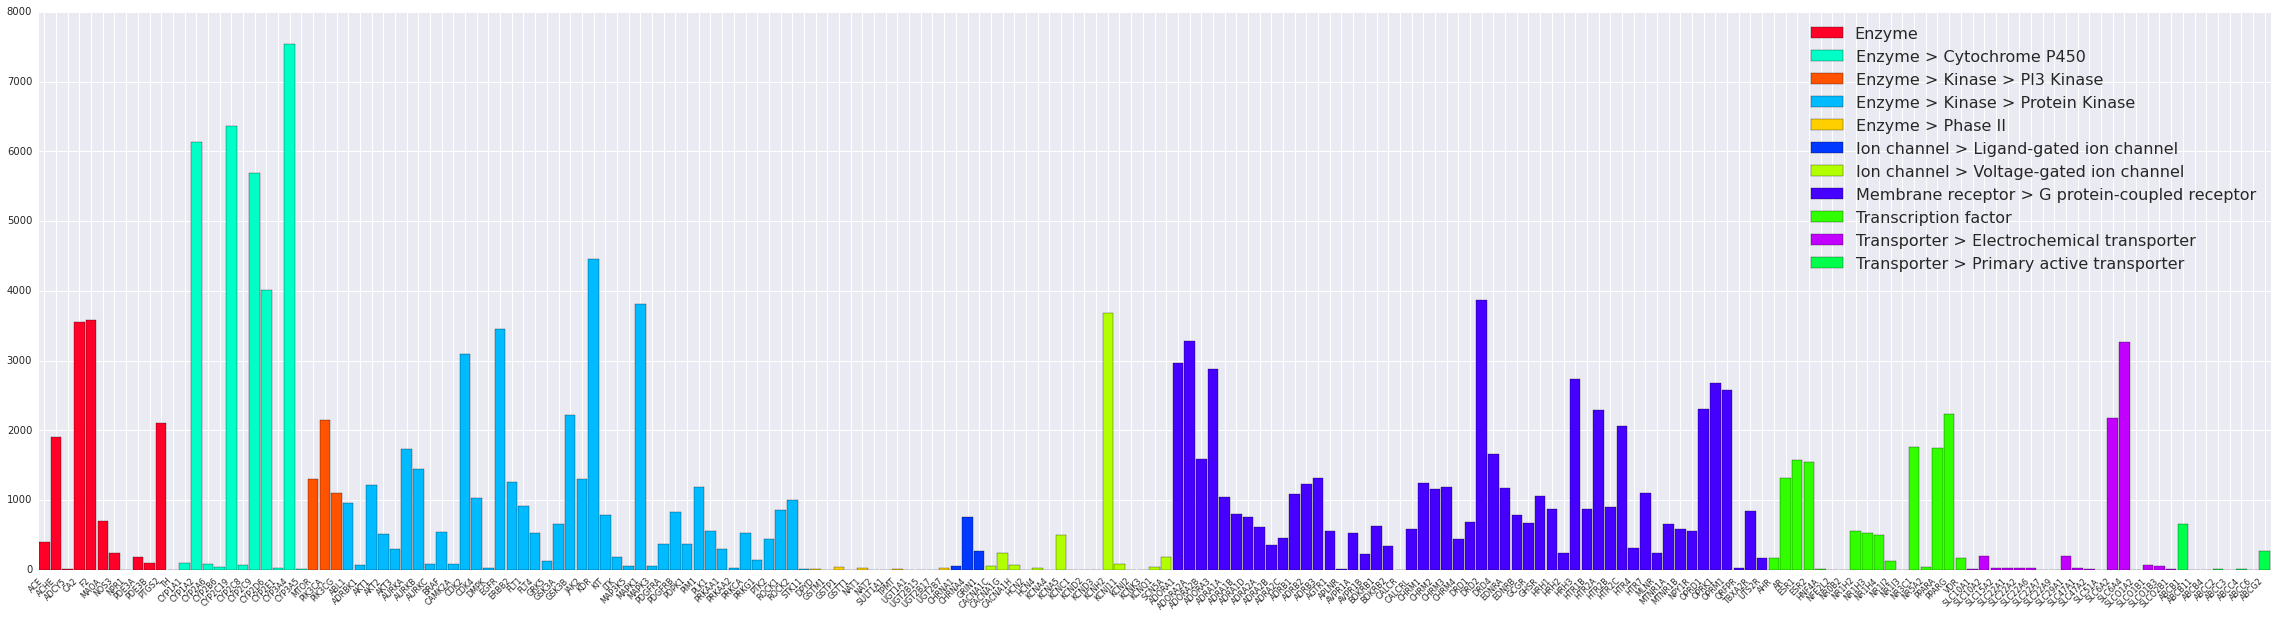

In [60]:
do_plot(symbols.sort(['target_class', 'symbol']))

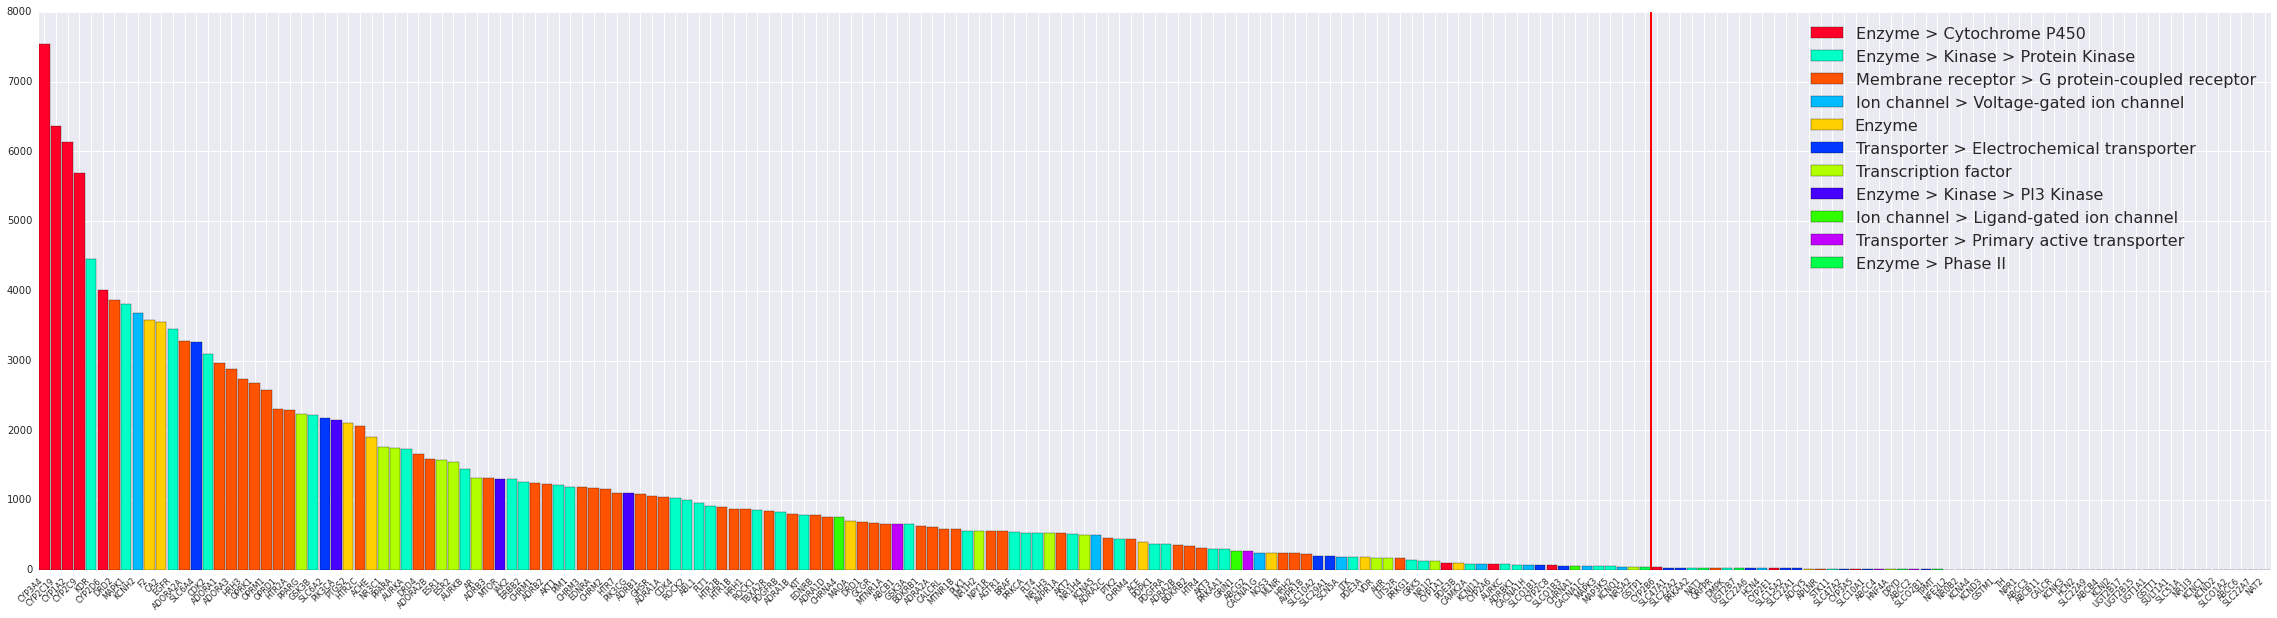

In [61]:
do_plot(symbols.sort('n_active', ascending=False), x_cutoff_value=40)

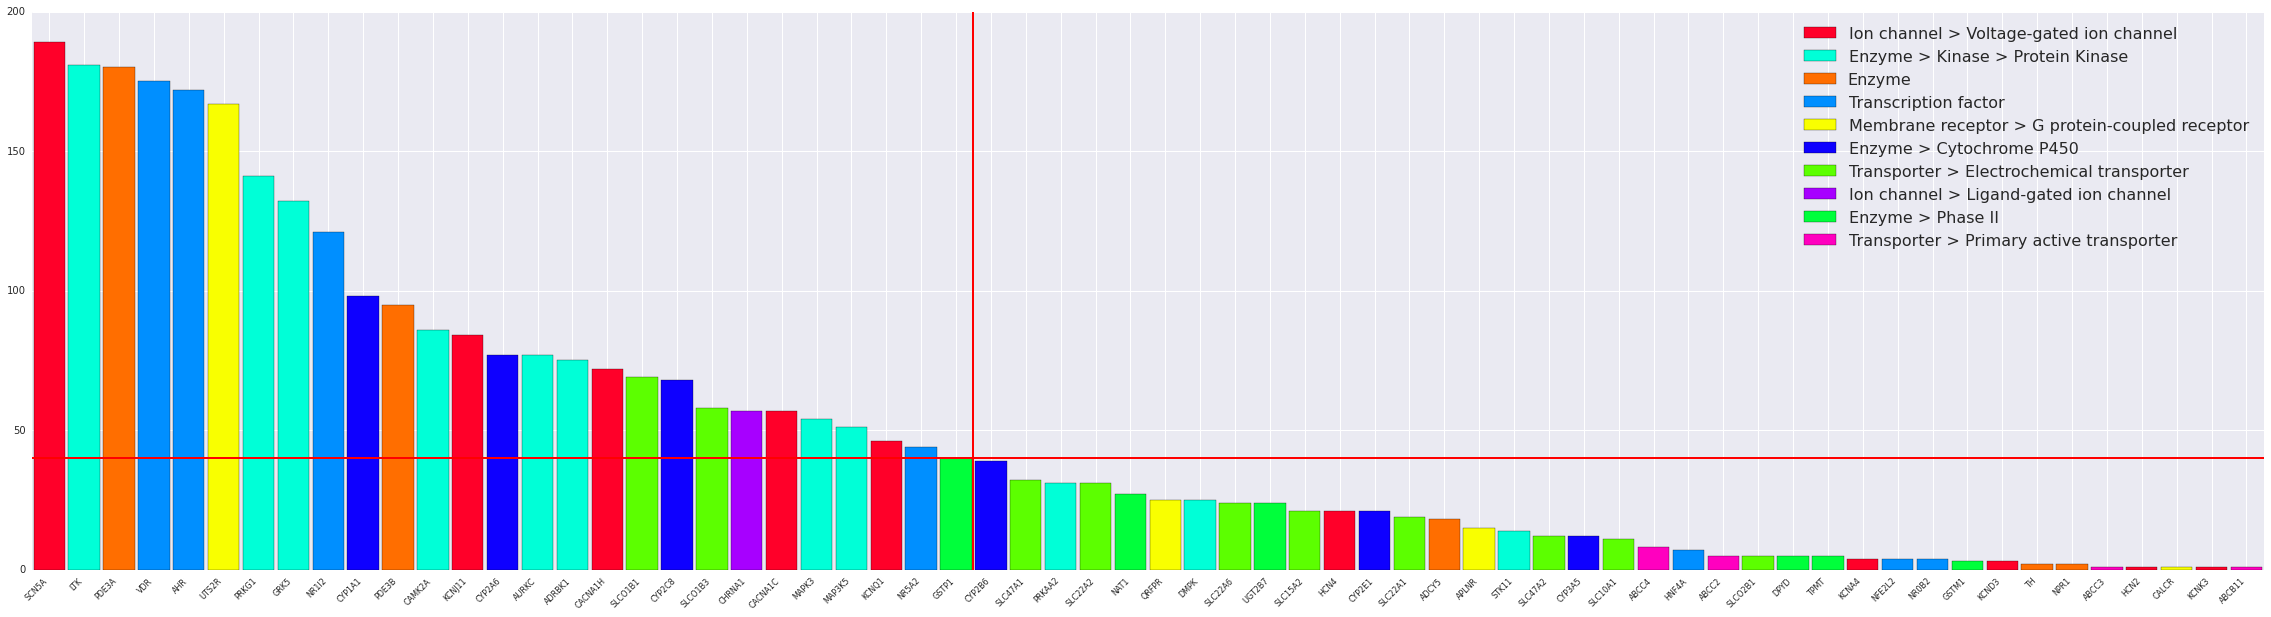

In [66]:
do_plot(symbols.query("n_active <= 200 and n_active > 0").sort('n_active', ascending=False), x_cutoff_value=40, y_cutoff=40)

## Symbols lost

In [46]:
# Threshold number of distinct active parent compounds...

min_n_active = 40

In [47]:
symbols.query('n_active >= @min_n_active').shape[0]

(138, 5)

In [55]:
symbols.query('n_active >= 100').shape[0]

120

In [48]:
lost = symbols.query('n_active < @min_n_active')

lost.shape

(53, 5)

### Classified

In [49]:
lost.query("target_class != 'Unclassified'")['target_class'].value_counts()

Transporter > Electrochemical transporter         12
Enzyme > Phase II                                 11
Ion channel > Voltage-gated ion channel            8
Transporter > Primary active transporter           6
Transcription factor                               4
Membrane receptor > G protein-coupled receptor     3
Enzyme > Cytochrome P450                           3
Enzyme > Kinase > Protein Kinase                   3
Enzyme                                             3
dtype: int64

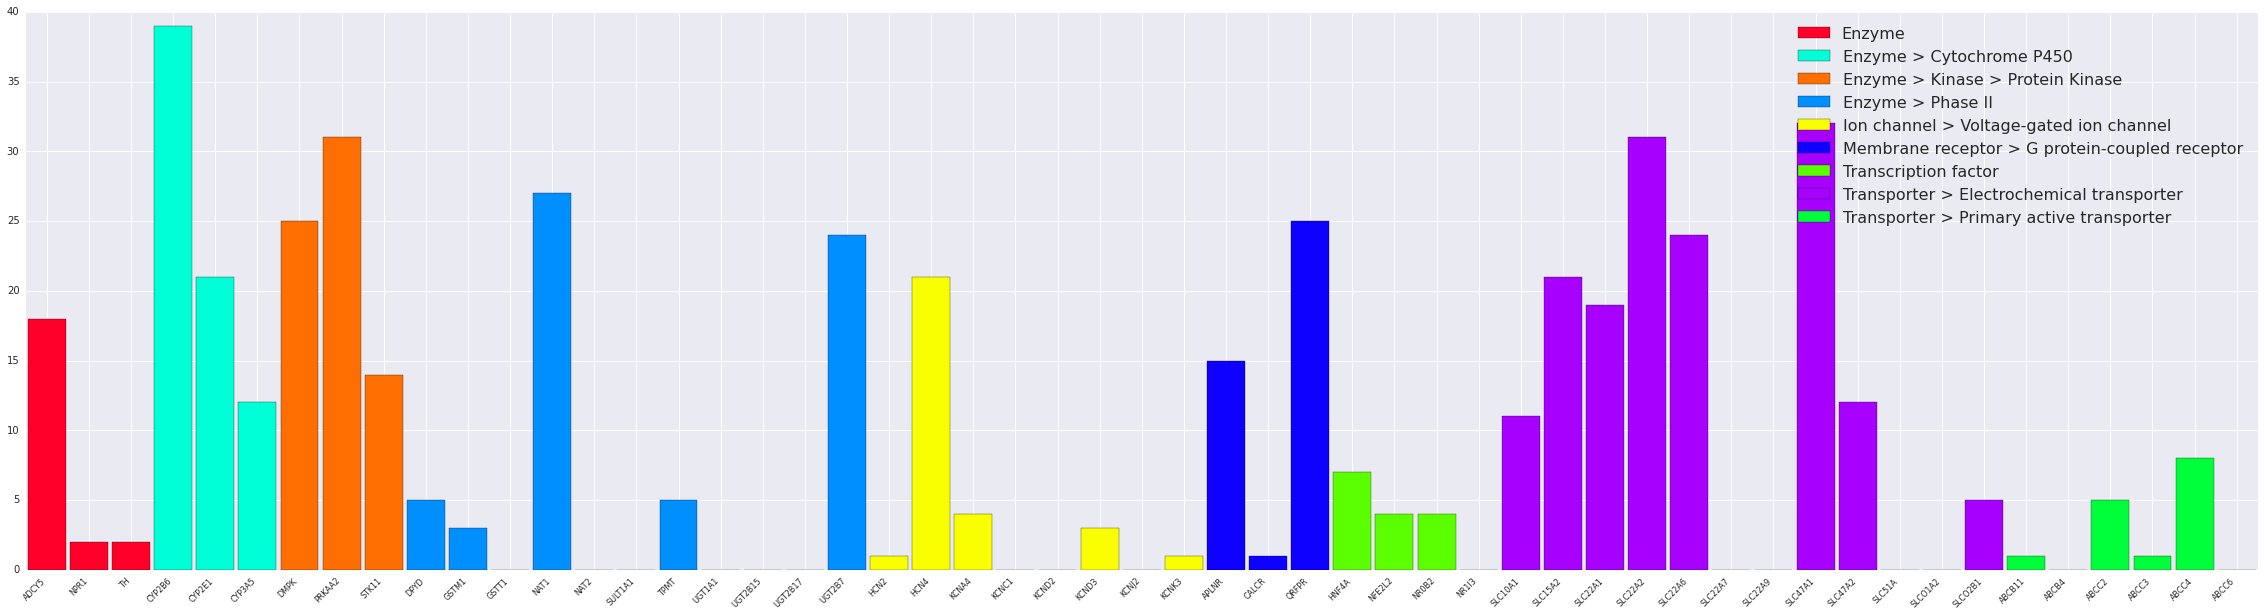

In [50]:
do_plot(lost.query("target_class != 'Unclassified'").sort(['target_class', 'symbol']))

In [51]:
def f(target, group):
    
    symbols = group['symbol'].values
        
    return {'targets': target, 'symbols': symbols, 'count': len(symbols)}
    
pd.DataFrame([f(x, y) for x, y in sorted(lost.groupby('targets'), key=lambda x: float(x[0][0][1]))], columns=['targets', 'symbols', 'count']).sort('count', ascending=False).reset_index(drop=True)

,targets,symbols,count
0,"((If, 4),)","[HCN2, HCN4]",2
1,"((Ito,f, 4),)","[KCND2, KCND3]",2
2,"((ANF, 2.2),)",[NPR1],1
3,"((UDP glucuronosyltransferase 2 family, polypeptide B7, 11),)",[UGT2B7],1
4,"((MRP6, 8),)",[ABCC6],1
5,"((CAR, 9),)",[NR1I3],1
6,"((HNF4α, 9),)",[HNF4A],1
7,"((Nrf2, 9),)",[NFE2L2],1
8,"((SHP, 9),)",[NR0B2],1
9,"((N-acetyltransferase 1 (arylamine N-acetyltransferase), 11),)",[NAT1],1
